<a href="https://colab.research.google.com/github/mrzzy/ntu-sc1015/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Modeling: Business Closure Prediction

In order to answer what makes a business stay open, we have to model the problem into a Binary Classification problem and predict whether a business will open or close:
- `0` This business has **closed**
- `1` This business is still **open**.


Objective: Train a Machine Learning (ML) model to predict whether an Yelp business will close:
- Problem: **Binary Classification** Predict whether the Yelp business is labeled as _open_ or _closed_.
- Machine Learning (ML) Algorithms: Logistic Regression, Random Forest & eXtreme Gradient Boosting (XGBoost).
- Evaluation Metric: F1-Score,
- Dataset: [Yelp Dataset](https://www.yelp.com/dataset)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil
from typing import Generic
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint, loguniform

sns.set_theme()

# Prepare Dataset

### Load Dataset
Load prepared Yelp Dataset

In [2]:
reviews_df = pd.read_parquet(
    "https://ntu-sc1015-yelp.s3.ap-southeast-1.amazonaws.com/yelp_reviews.parquet/part-00000-tid-666118639932506010-9f727aa9-11e6-466d-9314-69664704543d-2119-1-c000.snappy.parquet"
)

### Regroup Data
Cardinality of `reviews_df` is at the _reviews level_. We are specfically interested in business features at the _business level_.

Regroup data to the _business level_ and extract business features:


In [3]:
business_cols = reviews_df.columns[reviews_df.columns.str.startswith("business_")]
review_counts = reviews_df.groupby("business_id")["review_id"].count()
business_df = reviews_df[business_cols].groupby("business_id").first()
business_df["n_reviews"] = review_counts

### Target Variable
Given Yelp dataset features, we are trying to whether `business_is_open`:
- `0` This business has **closed**
- `1` This business is still **open**.


In [4]:
target = "business_is_open"
targets = business_df[target]
features = business_df.columns[business_df.columns != target]
feature_df = business_df[features]

### Split Dataset
Split dataset into train and test subsets using stratified random sampling to ensure consistent target distribution on train / test subsets.

In [5]:
train_feature_df, test_feature_df, train_targets, test_targets = train_test_split(
    feature_df, targets, test_size=0.2, random_state=42, stratify=targets
)

### Transform for ML
Apply transformations to data to convert it into a form suitable for Machine Learning.

#### Target: Business Is Open
Observing distribution of our target variable `business_is_open`, we can see an imbalance of open (1) and closed (0) businesses. This imbalance is undesirable as it may cause the model to over bias towards the over represented class. Additionally class imbalance causes evaluation metrics, especially accuracy to become unreliable in determining actual model performance.


<Axes: title={'center': 'business_is_open'}, ylabel='business_is_open'>

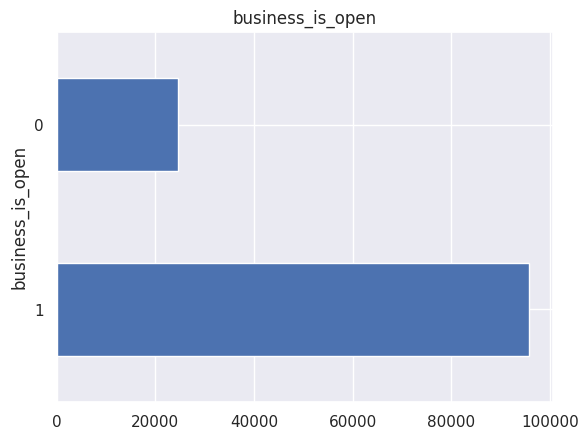

In [6]:
plt.title("business_is_open")
train_targets.value_counts().plot(kind="barh")

To combat imbalance, random under sampling of the majority class is done to balance out the no. of examples between classes.

Additionally F1 score, the harmonic mean between precision and recall is selected as the replacement metric to evaluate candidate models due to its robustness to class imbalance.


In [7]:
sampler = RandomUnderSampler(sampling_strategy="majority", random_state=42)

#### Business Rating
`business_stars`
- In Exploratory Data Analysis (EDA), we have observed that `business_stars` is left skewed, hence `np.exp2()` is applied to correct the skew.


In [8]:
unskew_stars_tfm = ("unskew_stars", FunctionTransformer(np.exp2, feature_names_out="one-to-one"), ["business_stars"])


#### No. of Reviews
`n_reviews`
- EDA shows that a good indicator of whether a business will close is the no. of reviews recieved by the business. In particular, if the business recieves no reviews, its highly likely to close.


In [9]:
n_reviews_tfm = ("passthrough", "passthrough", ["n_reviews"])

#### Business Main Category
`business_categories`
- EDA shows that `business_categories` is especially high cardinality, making it unsuitable for direct one hot encoding due to the exceeding large no. of columns.
- High cardinality is a result of `business_categories` being multiple category labels being concatenated together.
- We extract the  _main categories_ [^1] for each set of categories labels to lower cardinality to a manageable level (22 main categories).


[^1]: https://blog.yelp.com/businesses/yelp_category_list/

In [10]:
MAIN_CATEGORIES = {
    "Active Life",
    "Arts & Entertainment",
    "Automotive",
    "Beauty & Spas",
    "Education",
    "Event Planning & Services",
    "Financial Services",
    "Food",
    "Health & Medical",
    "Home Services",
    "Hotels & Travel",
    "Local Flavor",
    "Local Services",
    "Mass Media",
    "Nightlife",
    "Pets",
    "Professional Services",
    "Public Services & Government",
    "Religious Organizations",
    "Restaurants",
    "Shopping",
    "Others",
}


def filter_main(categories: pd.DataFrame) -> pd.DataFrame:
    """Filter categories to extract the first matching main category"""
    return (
        categories.iloc[:, 0]
        .fillna("")
        .str.split(", ")
        .apply(
            lambda categories: ", ".join(
                [c for c in categories if c in MAIN_CATEGORIES]
            )
        )
        .str.get_dummies(", ")
    )


main_category_tfm = (
    "main_category",
    make_pipeline(
        FunctionTransformer(filter_main, feature_names_out="one-to-one"),
        OneHotEncoder(sparse_output=False),
    ),
    ["business_categories"],
)

In [11]:
transform = ColumnTransformer(
    transformers=[
        unskew_stars_tfm,
        n_reviews_tfm,
        main_category_tfm,
    ]
)

#### All Features
`StandardScaler` is applied to normalise feature values to a range suitable for ML models.


In [12]:
scaler = StandardScaler()

# ML Modelling
To select an ML algorithm, Logistic Regression, Random Forest & XGBoost models are trained on training data and evaluated with stratified K Fold cross validation (K=5) to benchmark their relative performance on the dataset.

### ML Algorithms
Models will be built from the following ML Algorithms:

In [13]:
models = [
    LogisticRegression(),
    RandomForestClassifier(),
    XGBClassifier(),
]

### Model Evaluation
Model evaluation be performed on the following metrics:
- F1-score: Harmonic Mean of Precision and Recall
- Precision
- Recall
- Accuracy

Do to the presence of class imbalance, F1-score is choosen over Accuracy as the _core metric_ to benchmark Models for Model Selection.

In [14]:
metrics = [
    "f1",
    "precision",
    "recall",
    "accuracy",
]

### Train & Evaluation Lifecycle
Group data transformation, model training & evaluation steps into a single objective function:



In [15]:
def build_pipeline(model: BaseEstimator) -> Pipeline:
  # group data transform & model steps in single pipeline
  return Pipeline(
    steps=[
        ("sample_data", sampler),
        ("transform_data", transform),
        ("scale_data", scaler),
        ("model", model),
    ]
  )

def train_eval(
    pipeline: Pipeline, feature_df: pd.DataFrame, targets: pd.Series
) -> pd.DataFrame:
    # train & evaluate model with metrics
    results = cross_validate(
        estimator=pipeline,
        X=train_feature_df,
        y=train_targets,
        scoring=metrics,
        cv=5,
        return_train_score=True,
        # cross validate on all CPU cores
        n_jobs=-1,
    )

    # rename "test_" columns to "valid_" to reflect that they are derieved from validation set
    df = pd.DataFrame(results)
    df.columns = df.columns.str.replace("test_", "valid_")
    df["pipeline"] = str(pipeline)
    model = pipeline.named_steps["model"]
    df["model"] = str(model)
    df["model_class"] = str(model.__class__)
    return df

### Model Selection
Train models using different ML algorithms to determine optimum ML algorithm for task:
- Logistic Regression
- Random Forest
- eXtreme Gradient Boosting Trees (XGBoost)

In [16]:
%%time
results_df = pd.concat([train_eval(build_pipeline(m), train_feature_df, train_targets) for m in models])

CPU times: user 17.7 s, sys: 2.16 s, total: 19.9 s
Wall time: 1min 34s


In [17]:
results_df.groupby("model_class")["valid_f1"].mean().sort_values()

model_class
<class 'sklearn.linear_model._logistic.LogisticRegression'>    0.797952
<class 'sklearn.ensemble._forest.RandomForestClassifier'>      0.810122
<class 'xgboost.sklearn.XGBClassifier'>                        0.813560
Name: valid_f1, dtype: float64

Based on F1 score evaluated using K-Fold cross validation, XGBoost is the best performing.

### Hyperparameter Tuning
60 random samples of the following XGBoost Hyperparameters [^1] [^2] where evaluated on 80-20 train-validation split to find the optimal combination of Hyperparameters:
- `reg_alpha` (0 - 1000) L1 regularization applied to model weights.
- `min_child_weight` (0 - 120) Minimum weight of tree node, below which the XGBoost tree will not partition.
- `subsample` (0.5 - 1) Below 1, XGBoost will randomly select a subset of the training data to train on.
- `learning_rate` (0.1 - 0.5) Learning rate of each tree trained at the end of each boosting step.
- `n_estimators` (1 -  4000) No. of rounds of boosting to perform.

In particular, `reg_alpha`, `min_child_weight` , `subsample`, `learning_rate` are explored on a logarithmic scale to cover various orders of magnitude for these Hyperparameters.

[^1]: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html
[^2]: https://xgboost.readthedocs.io/en/stable/parameter.html

In [18]:
params = {
  "model__reg_alpha": loguniform(1e-9, 1000),
  "model__min_child_weight": loguniform(1e-9, 120),
  "model__subsample": loguniform(0.5, 1),
  "model__learning_rate": loguniform(0.1, 0.5),
  "model__n_estimators": randint(1, 4000),
}


Sample random combinations of Hyperparameters to find optimal combination of Hyperparameters.


Successive Halving is applied to quickly try out hyperparameter combinations on a sample of the training data, eliminating unpromising combinations early tornonament style. This reserves more computational resources to
exploring promising hyperparameter combinations, identified initial trails, in later trials with more data,  which are more computationally expensive.

In [19]:
%%time
search =  HalvingRandomSearchCV(
    build_pipeline(XGBClassifier()),
    params,
    cv=ShuffleSplit(n_splits=1, test_size=0.2, random_state=42),
    scoring="f1",
    return_train_score=True,
    resource="n_samples",
    min_resources="exhaust",
    n_candidates=60,
    random_state=42,
    n_jobs=-1,
).fit(train_feature_df, train_targets)

CPU times: user 2min 4s, sys: 11.5 s, total: 2min 16s
Wall time: 4min 42s


In [20]:
search.best_params_

{'model__learning_rate': 0.21984307903252542,
 'model__min_child_weight': 83.21469511575232,
 'model__n_estimators': 1440,
 'model__reg_alpha': 0.01295271132412025,
 'model__subsample': 0.528821715655488}

In [21]:
search.best_score_

0.8120584079133303

## Test Evaluation
Prior evaluations of model have been performed on validation sets sampled from the training data. This information has been used to tune Hyperparameters, which could have resulted in a overfit of Hyperparameters to training data.

A final evaluation of the best model's performance is performed on the a yet unseen test set to give a unbiased estimate of model performance and check for Hyperparameter overfitting:

In [22]:
model = search.best_estimator_
test_preds = model.predict(test_feature_df)
f1_score(test_targets, test_preds)

0.8202152550304166

## Feature Importances
Feature Importance values can be extracted from the XGBoost model. These values indicate how valuable each feature is influencing the model's prediction on whether a Yelp Business will survive.


<Axes: xlabel='Importance', ylabel='Feature'>

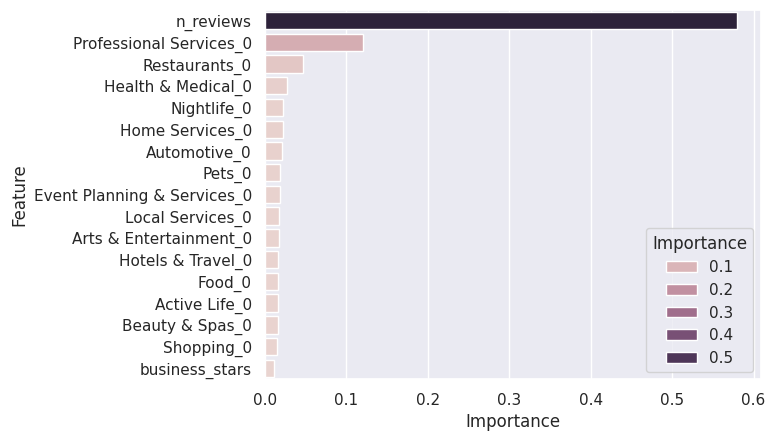

In [101]:
# tag feature importances with feature names
feature_names = ["business_stars", "n_reviews"] + list(model.named_steps["transform_data"].named_transformers_["main_category"].named_steps["onehotencoder"].get_feature_names_out())
importances = pd.Series(
    model.named_steps["model"].feature_importances_,
    index=feature_names,
).sort_values(ascending=False)

# filter out zero importance features
importance_df = importances[importances != 0].to_frame().reset_index()
importance_df.columns = ["Feature", "Importance"]
sns.barplot(importance_df, x="Importance", y="Feature", hue="Importance", orient="h")


Observing the Feature Importance plot above, we conclude that the `n_reviews` is the Key Predictor of a Yelp businesses ability to surivive.